## Calculando Largura de vias

A intenção aqui é experimentar uma metodoloogia para se calcular a larura de vias dadas as seguintes feições:
* Um polígono da via
* Uma linha aproximada ao trajeto central da via
* Poligono com as quadras adjacentes a via

Para tanto disponibilizamos um arquivo que podemos acessar assim:

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df_pvias = gpd.read_file("./gis/POC-largura-de-via.gpkg", layer='poligono-de-vias')

/home/fernando/miniconda3/envs/geoplot/lib/python3.9/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [3]:
df_lvias = gpd.read_file("./gis/POC-largura-de-via.gpkg", layer='logradouros')

In [4]:
df_quadras = gpd.read_file("./gis/POC-largura-de-via.gpkg", layer='quadras')

<AxesSubplot:>

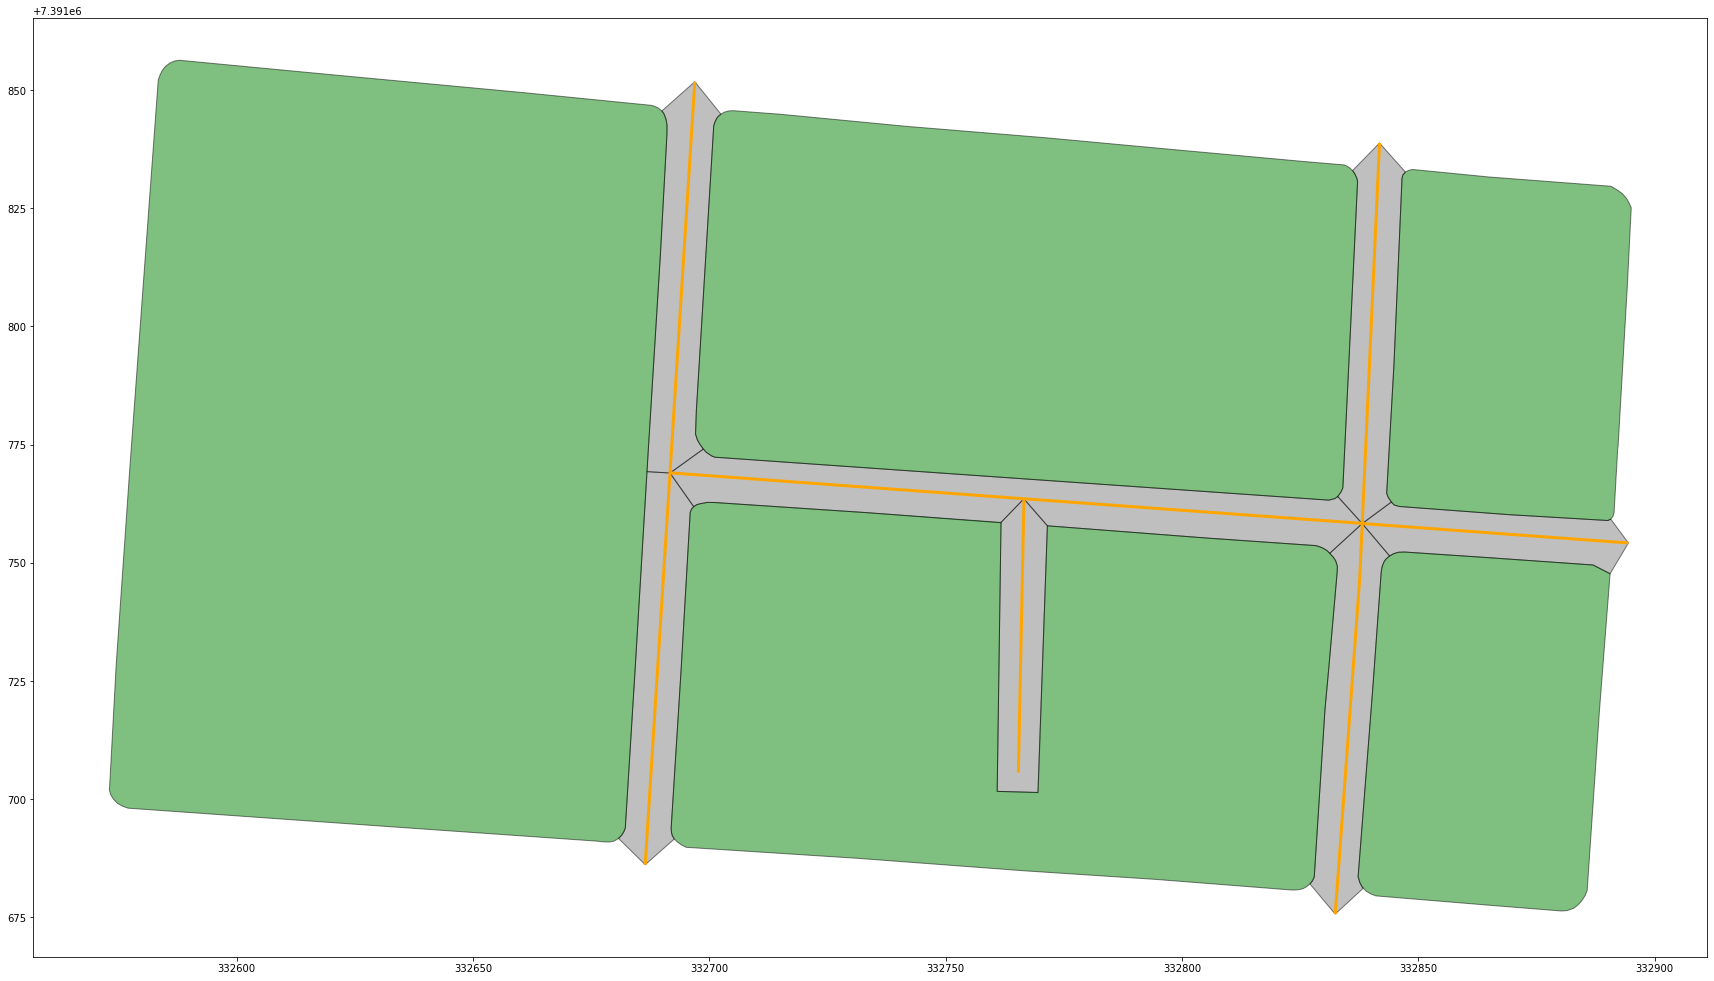

In [5]:
f, ax = plt.subplots(1, figsize=(30,20))
df_pvias.plot(ax=ax, color="grey", alpha=0.5, linewidth=1, edgecolor='black')
df_lvias.plot(ax=ax, color="orange", lw=3)
df_quadras.plot(ax=ax, color="green", alpha=0.5, linewidth=1, edgecolor='black')

## Dividir para conquistar

Primeira estratégia seria dividir a linha central da via em pequenos segmentos para depois encontrar os pontos próximos nas quadras adjacentes

In [6]:
df_lvias.apply(lambda x: [x.geometry.length], axis=1)

0     [82.84273643904555]
1     [80.59425436230332]
2     [82.95592474412558]
3     [83.04766092811225]
4    [146.85587046999353]
5     [56.47167724829081]
6     [57.98145765525419]
dtype: object

Uma estratégia que pode parecer interessante seria gerar um ponto a cada 12 metros para medirmos. Isso excluiria do cálculo os segumentos de via menores que 12 metros. Esse valor pode ser reconsiderado

In [7]:
import math
from shapely.geometry import MultiPoint

In [8]:
[(((i)*12)+6+(16%12)/2) for i in range(math.floor(42/12))]

[8.0, 20.0, 32.0]

In [9]:
dist = 12.00

points = df_lvias.apply(lambda x: MultiPoint([x.geometry.interpolate(((i)*dist)+dist/2+(x.geometry.length%dist)/2) 
                                              for i in range(math.floor(x.geometry.length/dist))]), 
                        axis=1)

df_points = gpd.GeoDataFrame(geometry=points)

<AxesSubplot:>

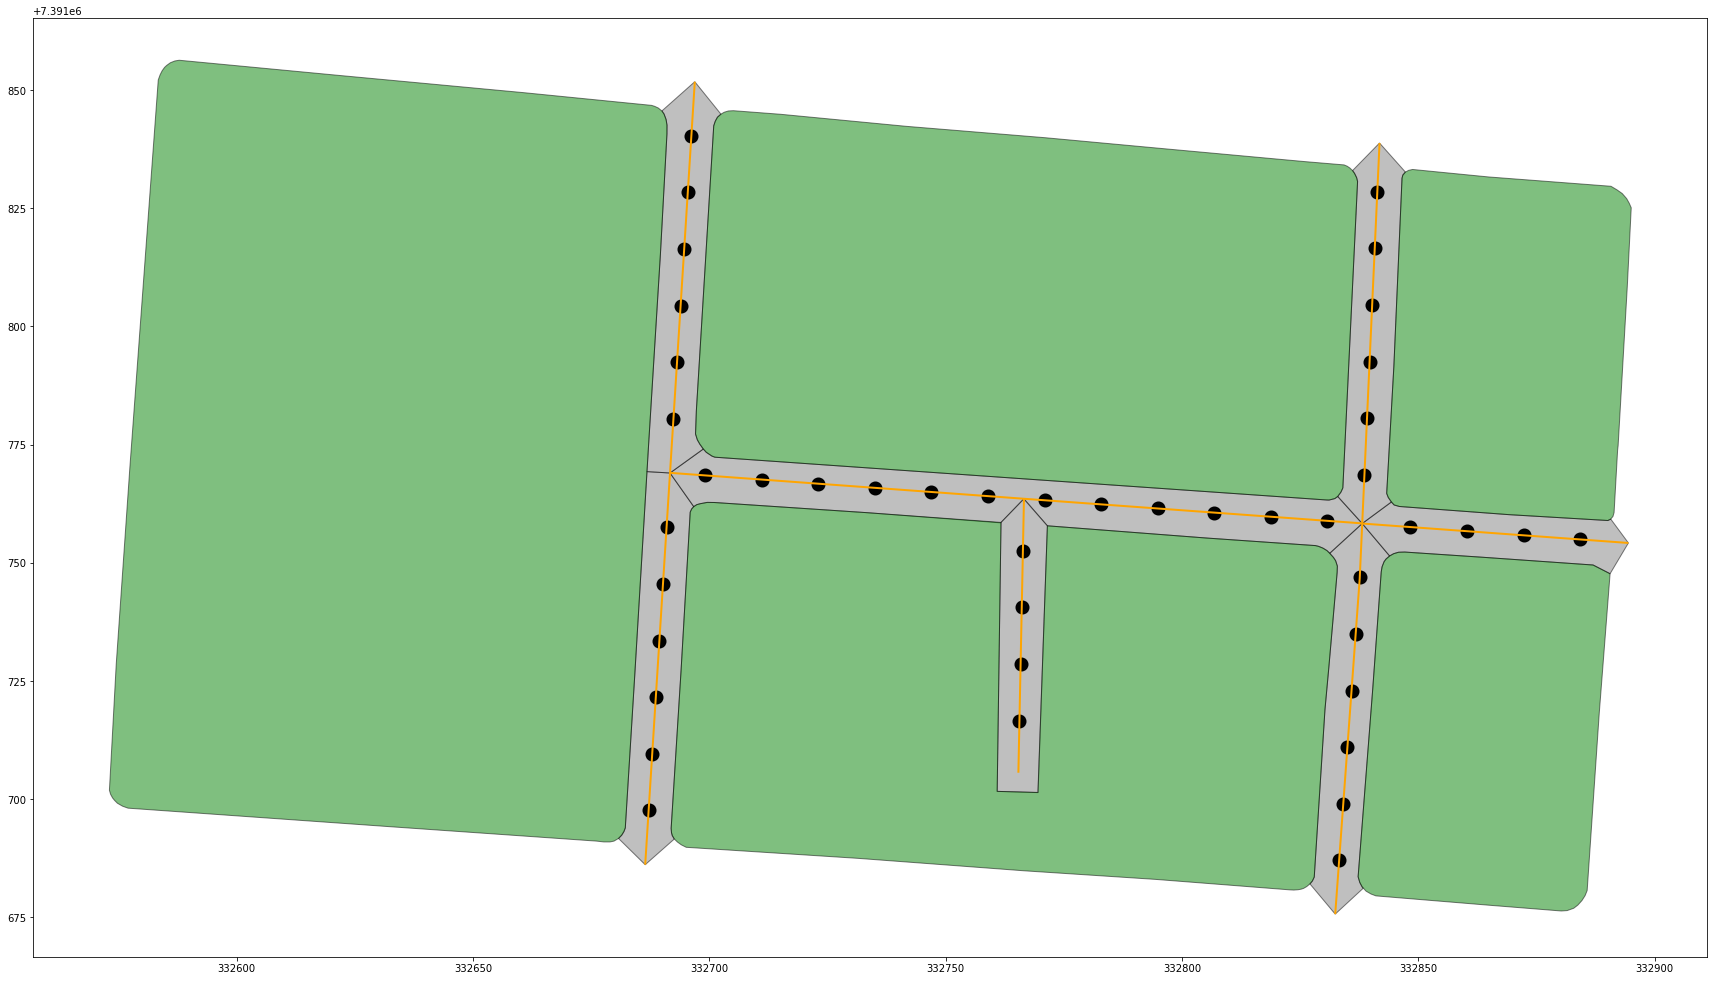

In [10]:
f, ax = plt.subplots(1, figsize=(30,20))
df_pvias.plot(ax=ax, color="grey", alpha=0.5, linewidth=1, edgecolor='black')
df_lvias.plot(ax=ax, color="orange", lw=2)
df_quadras.plot(ax=ax, color="green", alpha=0.5, linewidth=1, edgecolor='black')
df_points.plot(ax=ax, lw=4, marker='o', markersize=100, color='black')

Agora temos que relacionar esses pontos seu respectivo polígono de via para depois saber quais são as suas quadras adjacentes, para então medir a sua distância até elas

## Quebrando a geometria do polígono de vias

Vamos quebrar a borda do polígono de vias em dois segmentos laterais para relacionar a distância.

A estratégia é quebra-lo pelos pontos inicial e final da linha da via

In [11]:
from shapely.geometry import Point, MultiLineString, LineString, MultiPoint
from shapely.ops import substring, nearest_points, split, linemerge

In [12]:
df_pvias

,geometry
0,"POLYGON ((332838.357 7391681.144, 332832.412 7..."
1,"POLYGON ((332692.571 7391691.545, 332686.408 7..."
2,"POLYGON ((332890.572 7391747.677, 332886.974 7..."
3,"POLYGON ((332831.250 7391752.001, 332830.666 7..."
4,"POLYGON ((332844.298 7391762.855, 332838.124 7..."
5,"POLYGON ((332691.658 7391768.991, 332686.787 7..."
6,"POLYGON ((332766.516 7391763.501, 332761.697 7..."


In [13]:
def ponto_maior_borda(g):
    linhas_de_borda = split(MultiPoint(g.coords[:]).convex_hull.boundary, MultiPoint(g.coords[:]))
    maior_borda = max(linhas_de_borda, key=(lambda x: x.length))
    ponto_maior_borda = Point(maior_borda.coords[0])
    return ponto_maior_borda

df_pvias['geometry_ponto_inicial'] = gpd.GeoDataFrame(geometry=df_pvias.exterior.apply(lambda x: ponto_maior_borda(x)))
# bd = split(MultiPoint(pontos).convex_hull.boundary, MultiPoint(pontos))
# df_pvias.exterior.apply(lambda x: )

In [14]:
df_pvias

,geometry,geometry_ponto_inicial
0,"POLYGON ((332838.357 7391681.144, 332832.412 7...",POINT (332843.9214573102 7391751.43553768)
1,"POLYGON ((332692.571 7391691.545, 332686.408 7...",POINT (332680.7640983756 7391691.66214905)
2,"POLYGON ((332890.572 7391747.677, 332886.974 7...",POINT (332890.5719396115 7391747.677085)
3,"POLYGON ((332831.250 7391752.001, 332830.666 7...",POINT (332831.2498891531 7391752.001060824)
4,"POLYGON ((332844.298 7391762.855, 332838.124 7...",POINT (332847.2651335474 7391832.665801891)
5,"POLYGON ((332691.658 7391768.991, 332686.787 7...",POINT (332686.7865216365 7391769.28399341)
6,"POLYGON ((332766.516 7391763.501, 332761.697 7...",POINT (332760.8860032775 7391701.62490209)


In [15]:
def bordas(r):
    ponto_inicial = r.geometry.boundary.project(r.geometry_ponto_inicial, normalized=True)
    borda = r.geometry.boundary.difference(r.geometry_ponto_inicial.buffer(1))
    borda_merged = linemerge(borda) if borda.type != 'LineString' else borda
    bordas = MultiLineString([substring(borda_merged, 0, 0.5, normalized=True), substring(borda_merged, 0.5, 1, normalized=True)])
    return bordas

df_pvias['geometry_bordas'] = df_pvias.apply(lambda x: bordas(x), axis=1)

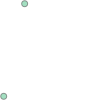

In [16]:
df_pvias.geometry_bordas.iloc[0][1].boundary

In [17]:
df_point_to_border = gpd.sjoin(df_points.explode(), df_pvias, op='within')

In [18]:
df_point_to_border

geometry  index_right  \
0 0   POINT (332837.605 7391746.888)            0   
  1   POINT (332836.738 7391734.920)            0   
  2   POINT (332835.864 7391722.952)            0   
  3   POINT (332834.990 7391710.984)            0   
  4   POINT (332834.117 7391699.015)            0   
  5   POINT (332833.243 7391687.047)            0   
1 0   POINT (332841.319 7391828.522)            4   
  1   POINT (332840.773 7391816.535)            4   
  2   POINT (332840.228 7391804.547)            4   
  3   POINT (332839.683 7391792.560)            4   
  4   POINT (332839.137 7391780.572)            4   
  5   POINT (332838.592 7391768.584)            4   
2 0   POINT (332696.176 7391840.326)            5   
  1   POINT (332695.418 7391828.350)            5   
  2   POINT (332694.659 7391816.374)            5   
  3   POINT (332693.901 7391804.398)            5   
  4   POINT (332693.142 7391792.422)            5   
  5   POINT (332692.383 7391780.446)            5   
3 0   POINT (332690.929 7391757.491)            1   
  1   POINT (332690.171 7391745.515)            1   
  2   POINT (332689.412 7391733.539)            1   
  3   POINT (332688.654 7391721.563)            1   
  4   POINT (332687.895 7391709.587)            1   
  5   POINT (332687.137 7391697.611)            1   
4 0   POINT (332699.095 7391768.481)            3   
  1   POINT (332711.063 7391767.605)            3   
  2   POINT (332723.031 7391766.728)            3   
  3   POINT (332734.999 7391765.852)            3   
  4   POINT (332746.967 7391764.975)            3   
  5   POINT (332758.935 7391764.099)            3   
  6   POINT (332770.903 7391763.225)            3   
  7   POINT (332782.871 7391762.353)            3   
  8   POINT (332794.839 7391761.482)            3   
  9   POINT (332806.808 7391760.611)            3   
  10  POINT (332818.776 7391759.740)            3   
  11  POINT (332830.744 7391758.869)            3   
5 0   POINT (332848.333 7391757.553)            2   
  1   POINT (332860.301 7391756.679)            2   
  2   POINT (332872.269 7391755.805)            2   
  3   POINT (332884.237 7391754.931)            2   
6 0   POINT (332766.328 7391752.553)            6   
  1   POINT (332766.084 7391740.555)            6   
  2   POINT (332765.840 7391728.558)            6   
  3   POINT (332765.595 7391716.560)            6   

                           geometry_ponto_inicial  \
0 0    POINT (332843.9214573102 7391751.43553768)   
  1    POINT (332843.9214573102 7391751.43553768)   
  2    POINT (332843.9214573102 7391751.43553768)   
  3    POINT (332843.9214573102 7391751.43553768)   
  4    POINT (332843.9214573102 7391751.43553768)   
  5    POINT (332843.9214573102 7391751.43553768)   
1 0   POINT (332847.2651335474 7391832.665801891)   
  1   POINT (332847.2651335474 7391832.665801891)   
  2   POINT (332847.2651335474 7391832.665801891)   
  3   POINT (332847.2651335474 7391832.665801891)   
  4   POINT (332847.2651335474 7391832.665801891)   
  5   POINT (332847.2651335474 7391832.665801891)   
2 0    POINT (332686.7865216365 7391769.28399341)   
  1    POINT (332686.7865216365 7391769.28399341)   
  2    POINT (332686.7865216365 7391769.28399341)   
  3    POINT (332686.7865216365 7391769.28399341)   
  4    POINT (332686.7865216365 7391769.28399341)   
  5    POINT (332686.7865216365 7391769.28399341)   
3 0    POINT (332680.7640983756 7391691.66214905)   
  1    POINT (332680.7640983756 7391691.66214905)   
  2    POINT (332680.7640983756 7391691.66214905)   
  3    POINT (332680.7640983756 7391691.66214905)   
  4    POINT (332680.7640983756 7391691.66214905)   
  5    POINT (332680.7640983756 7391691.66214905)   
4 0   POINT (332831.2498891531 7391752.001060824)   
  1   POINT (332831.2498891531 7391752.001060824)   
  2   POINT (332831.2498891531 7391752.001060824)   
  3   POINT (332831.2498891531 7391752.001060824)   
  4   POINT (332831.2498891531 7391752.001060824)   
  5   POINT (332831.2498891531 7391752.001060824)   

In [19]:
def calc_distancia(p):
    l_dist = LineString([nearest_points(p.geometry, p.geometry_bordas[0])[1], 
                         nearest_points(p.geometry, p.geometry_bordas[1])[1]])
    if p.geometry.distance(l_dist) < 0.5:
        return l_dist
    
df_dists = gpd.GeoDataFrame(geometry=df_point_to_border.apply(lambda x: calc_distancia(x), axis=1))

<AxesSubplot:>

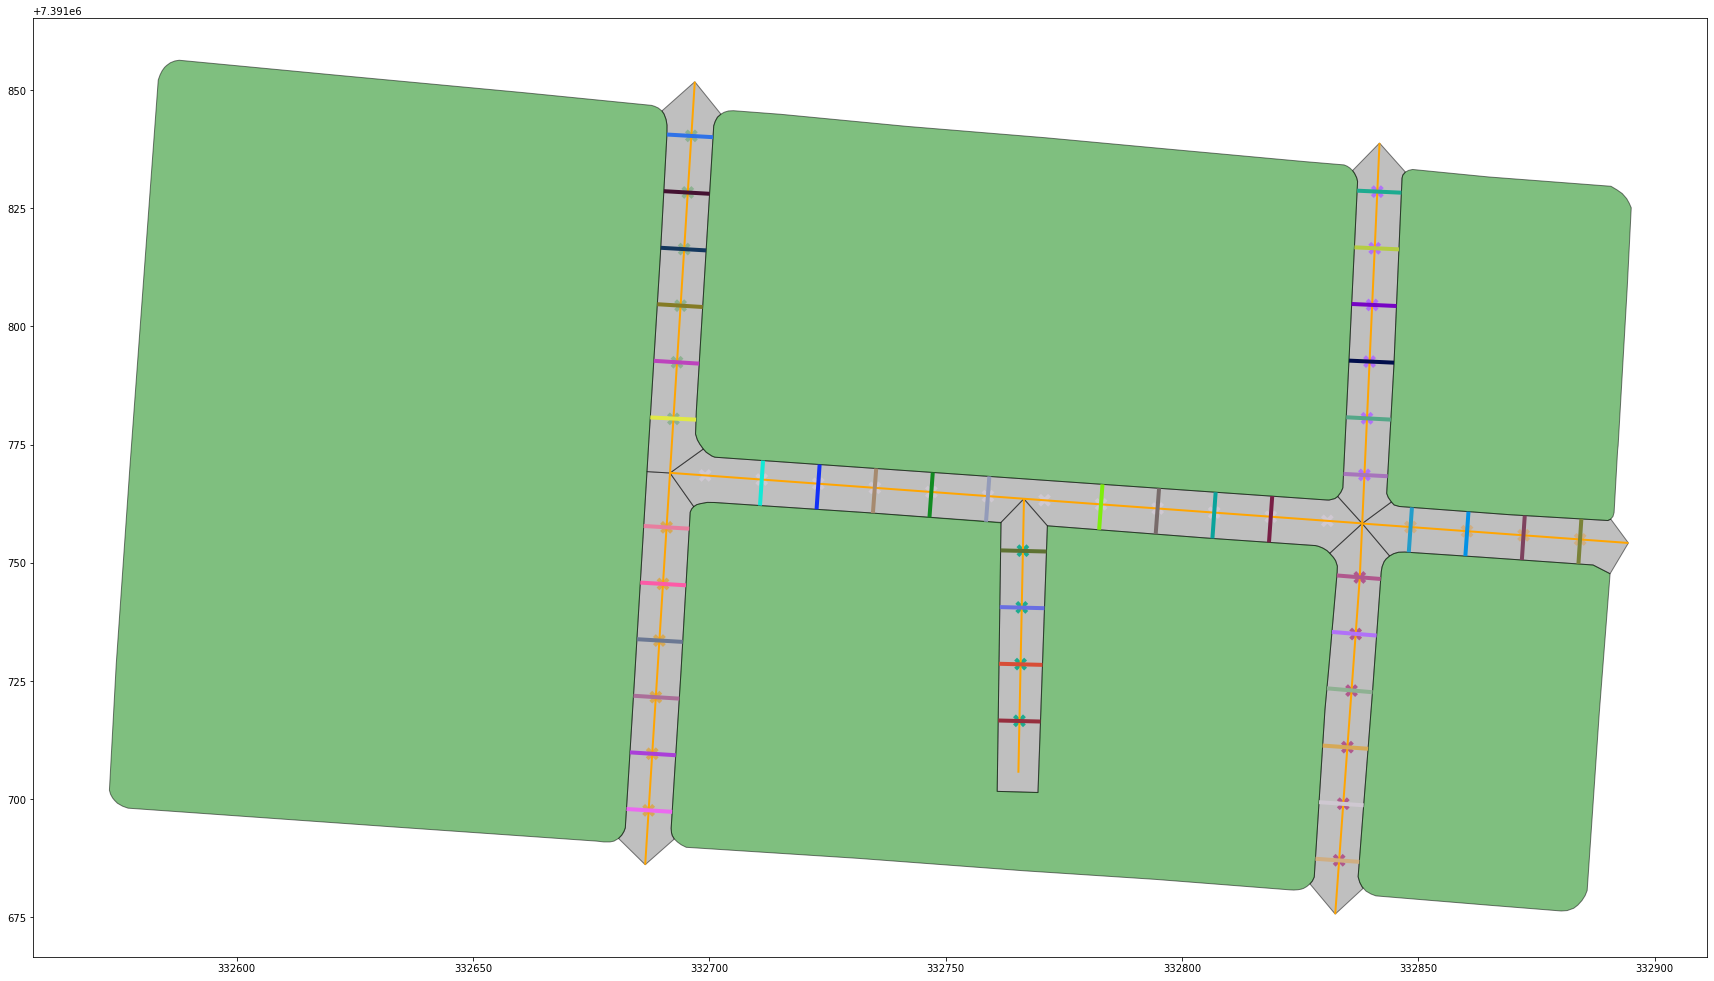

In [20]:
import numpy as np
f, ax = plt.subplots(1, figsize=(30,20))
df_pvias.plot(ax=ax, color="grey", alpha=0.5, linewidth=1, edgecolor='black')
df_lvias.plot(ax=ax, color="orange", lw=2)
df_quadras.plot(ax=ax, color="green", alpha=0.5, linewidth=1, edgecolor='black')

c = np.random.rand(len(df_dists), 3)

df_dists.plot(ax=ax,lw=4, color=c)
df_points.plot(ax=ax, lw=4, marker='x', markersize=100, color=c)